In [1]:
from __future__ import division # uncomment this if using Python 2.7
import numpy as np
from scipy import signal, spatial
from scipy.ndimage import gaussian_filter, sobel
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature, util
from sklearn import metrics
from skimage.morphology import erosion, disk 
import random
import time
from math import *


%matplotlib inline
from IPython.display import HTML, display

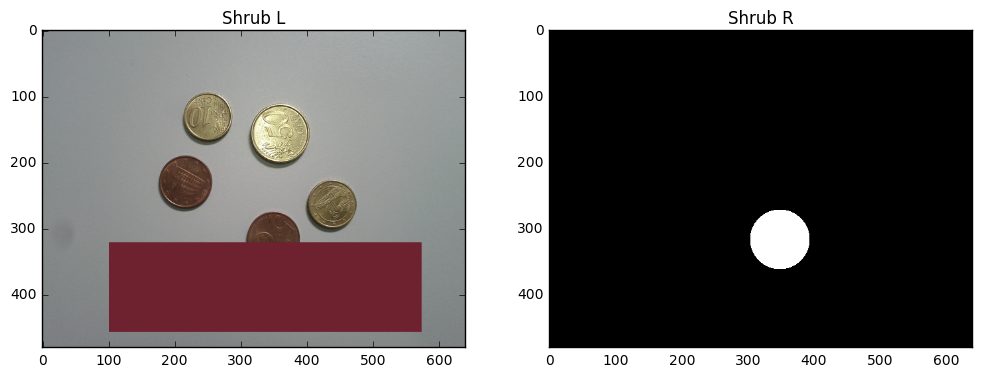

In [19]:
RGBimg1 = data.imread('coins.png')
img1 = img_as_float(color.rgb2gray(RGBimg1))

RGBmask = data.imread('coin-mask.png')
mask = img_as_float(color.rgb2gray(RGBmask))
#se sfondo bianco:
#mask= -(mask-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(RGBimg1, cmap=cm.gist_gray)
plt.title('Shrub L')
plt.subplot(122)
plt.imshow(RGBmask, cmap=cm.gist_gray)
plt.title('Shrub R');


In [11]:
# Dato un insieme di punti restituisce un array di patches di dimensione size_w

def get_patches(img, points, size_w):
    """
    - img: (n, m) input RGB image
    - points: (n, m) position of corners
    - w: integer patch size
    """
    patches=[]
    img3=np.lib.pad(img, ((size_w//2, size_w//2),(size_w//2,size_w//2)), 'edge')
    for i in points:
        patches.append(np.array(img3[i[0]:i[0]+2*size_w//2, i[1]:i[1]+2*size_w//2].flatten()))
        
    return patches


In [16]:
#Misura la distanza tra una patch e tutte le altre patches2, ritorna i pixel più vicini
def spectral_matching(sim, patches1, patches2, maskinv, corner_pos1,corner_pos2):
    """define a similarity measure between Euclidean and SSD and correlation"""
   
    patches2 = [x*maskinv for x in patches2]
    
    patches1=patches1*maskinv
    matchall=spatial.distance.cdist(patches1, patches2, sim)
     
    match=[]
    for i in range(matchall.shape[0]):
        match.append((corner_pos1, corner_pos2[np.argmin(matchall[i])]))

    return match

In [17]:
def show_match(match,img1, mask):
    """show match on side-by-side images"""
    
    superimg=np.zeros((img1.shape[0], img1.shape[1]+mask.shape[1]))
    superimg[:,:img1.shape[1]]=img1
    superimg[:,img1.shape[1]:]=mask
    
    plt.figure(figsize=(12,6))
    plt.imshow(superimg, cmap='gray')
    plt.title('Superimage')
    
    for i in range(len(match)):
        plt.plot([match[i][0][1], match[i][1][1]+img1.shape[1]], [match[i][0][0], match[i][1][0]])
    
    return 0

In [21]:
def find_simSSD(image, template, templatePoint, mask, size_w):
    fsize=(size_w//2)*2
    hsize_w=(size_w//2)
    rowp=image.shape[0]-hsize_w-1
    colsp=image.shape[1]-hsize_w-1
    distances= np.zeros((rowp,colsp)) 
    for d1 in range(rowp-1):
        for d2 in range(colsp-1):
            if ( d1<=hsize_w or d1>=rowp or d2<=hsize_w or d2>=colsp or 1 in mask[d1:d1+(hsize_w*2), d2:d2+(hsize_w*2)]):
                distances[d1][d2] = 1000#todo
            else:
                p1=image[d1:d1+9, d2:d2+9]
                distances[d1][d2] = np.sum((p1[:,:]-template[:,:])**2)
    x,y  = np.unravel_index(np.argmin(distances), distances.shape)   
    return (x+hsize_w,y+hsize_w)

def find_simNCC(image, template, templatePoint, mask, size_w):
    hsize_w=size_w//2
    template = np.copy(image[templatePoint[0]-hsize_w:templatePoint[0]+hsize_w,templatePoint[1]-hsize_w:templatePoint[1]+hsize_w])

    corr=match_template(image, template)
    x, y = np.unravel_index(np.argmax(corr), corr.shape)   
    #se la patch trovata overlappa la maschera ne cerco un altra
    while(1 in get_patches(mask, [(x,y)], size_w)[0]):
        corr[x,y] = -1
        x,y  = np.unravel_index(np.argmax(corr), corr.shape)   
    return (x,y)

/home/pietro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in double_scalars


Pixels rimasti: 
6349
Pixels rimasti: 
5946
Pixels rimasti: 
5496
Pixels rimasti: 
5046


/home/pietro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide


Pixels rimasti: 
4596
Pixels rimasti: 
4216
Pixels rimasti: 
4133
Pixels rimasti: 
4077
Pixels rimasti: 
3987
Pixels rimasti: 
3931
Pixels rimasti: 
3521
Pixels rimasti: 
3309
Pixels rimasti: 
2879
Pixels rimasti: 
2595
Pixels rimasti: 
2339
Pixels rimasti: 
2262
Pixels rimasti: 
2232
Pixels rimasti: 
1932
Pixels rimasti: 
1782
Pixels rimasti: 
1427
Pixels rimasti: 
1194
Pixels rimasti: 
1099
Pixels rimasti: 
776
Pixels rimasti: 
506
Pixels rimasti: 
390
Pixels rimasti: 
255
Pixels rimasti: 
126
Pixels rimasti: 
24
--- 43.1233520508 seconds ---


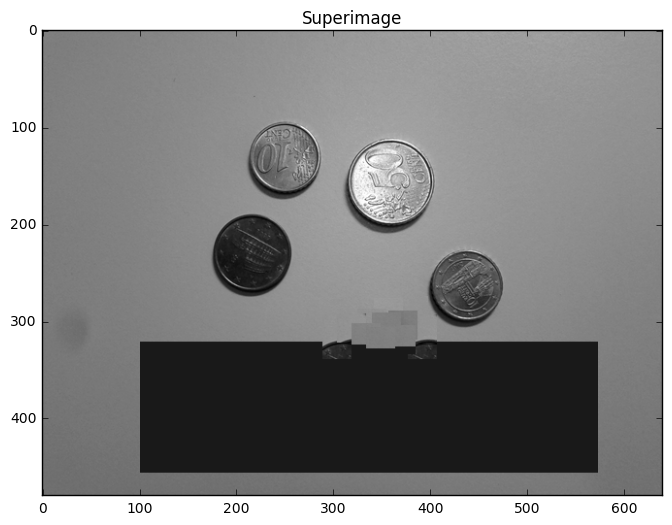

In [24]:
size_w=30
hsize_w=size_w//2

masknew=mask.copy()
imgnew = img1.copy()
imgblur = gaussian_filter(imgnew, sigma=1, order=0)

start_time = time.time()

#confidence iniziale
def setConfidence(borderI, confidence, imgnew):
    for idx, i in enumerate(borderI):
        confidence[i[0],i[1]]=sum(get_patches(confidence, [i], size_w)[0])/size_w**2
        
#aggiorno la confidence copiandola dalla patch    
def updateConfidence(confidence, match):
    pivotI_xmin=match[0][0][0]-hsize_w
    pivotI_xmax=match[0][0][0]+hsize_w
    pivotI_ymin=match[0][0][1]-hsize_w
    pivotI_ymax=match[0][0][1]+hsize_w
    
    match_xmin=match[0][1][0]-hsize_w
    match_xmax=match[0][1][0]+hsize_w
    match_ymin=match[0][1][1]-hsize_w
    match_ymax=match[0][1][1]+hsize_w
    
    confidence[pivotI_xmin:pivotI_xmax, pivotI_ymin:pivotI_ymax]=confidence[match_xmin:match_xmax, match_ymin:match_ymax]


#D(p)*C(p)
#return bordo maggiore priorità
def computeP(borderI, confidence, imgnew):
    for idx, i in enumerate(borderI):
        patchblur=get_patches(imgblur, [i], size_w)[0].reshape((size_w,size_w))
        patchmask=get_patches(masknew, [i], size_w)[0].reshape((size_w,size_w))
        dx = sobel(patchblur, axis=0)
        dy = -sobel(patchblur, axis=1)
        nx = sobel(patchmask, axis=0)
        ny = sobel(patchmask, axis=1) 

        mod = np.sqrt(dx ** 2 + dy ** 2)
        modI=(np.unravel_index(mod.argmax(), mod.shape))
        
        v1=np.array([dx[modI[0],modI[1]],dy[modI[0],modI[1]]])
        v2=np.array([ny[hsize_w,hsize_w],nx[hsize_w,hsize_w]]).T
        
        D = abs(np.dot(v1,v2/np.linalg.norm(v2)))
        D /= (sqrt(dy[modI[0], modI[1]] ** 2 + dx[modI[0], modI[1]] ** 2) *
                      sqrt(nx[hsize_w,hsize_w] ** 2 + ny[hsize_w,hsize_w] ** 2))
        
        borderC[idx]=confidence[i[0],i[1]]*D
        
    indx=np.argmax(borderC)
    maxI = borderI[indx]
    return maxI
    
#seleziono patches nell'immagine ogni window pixel
patchesIndex = [(ix,iy) for ix, row in enumerate(imgnew) for iy, i in enumerate(row) if (ix>size_w and iy>size_w and ix<imgnew.shape[0]-size_w and iy<imgnew.shape[1]-size_w and ix%hsize_w==0 and iy%hsize_w==0) and ( 1 not in get_patches(mask, [(ix,iy)], size_w)[0]) ]
patches = get_patches(imgnew, patchesIndex, size_w)

confidence = 1. - masknew.copy()

border = masknew - erosion(masknew, disk(1))
borderI =  [(ix,iy) for ix, row in enumerate(border) for iy, i in enumerate(row) if i==1 ]  
borderC=[0] * len(borderI)
setConfidence(borderI, confidence, imgnew)
    
while (masknew==1).sum()>0 :

#calcolo bordi della patch
    border = masknew - erosion(masknew, disk(1))
    borderI =  [(ix,iy) for ix, row in enumerate(border) for iy, i in enumerate(row) if i==1 ]  
    borderC=[0] * len(borderI)
    
    pivotI=computeP(borderI, confidence, imgnew)
    
#quanti punti rimangono nella mask
    print("Pixels rimasti: ")
    print((masknew==1).sum())
    
#seleziono un bordo con massima priorità
   
    pivotPatch = get_patches(imgnew, [pivotI], size_w)

#cerco tra le patch quella con distanza minima dal pivot
    maskpatch= -(get_patches(masknew, [pivotI], size_w)[0]-1)
    match=spectral_matching('euclidean', pivotPatch, patches, maskpatch, pivotI, patchesIndex)

#sostituisco la patch trovata e aggiorno la maschera
    pivotI_xmin=match[0][0][0]-hsize_w
    pivotI_xmax=match[0][0][0]+hsize_w
    pivotI_ymin=match[0][0][1]-hsize_w
    pivotI_ymax=match[0][0][1]+hsize_w
    
    match_xmin=match[0][1][0]-hsize_w
    match_xmax=match[0][1][0]+hsize_w
    match_ymin=match[0][1][1]-hsize_w
    match_ymax=match[0][1][1]+hsize_w
    
    imgnew[pivotI_xmin:pivotI_xmax, pivotI_ymin:pivotI_ymax]=imgnew[match_xmin:match_xmax, match_ymin:match_ymax]
    masknew[pivotI_xmin:pivotI_xmax, pivotI_ymin:pivotI_ymax]=0
    
    updateConfidence(confidence,match)

print("--- %s seconds ---" % (time.time() - start_time))
plt.figure(figsize=(12,6))
plt.imshow(imgnew, cmap='gray')
plt.title('Superimage')
